In [1]:
import sys 
sys.path.append(r'C:\Users\Behshad\Google Drive\codes\ScenarioGenerator')

In [2]:
from yamlParseObjects.yamlObjects import * 
from yamlParseObjects.variablesUtil import *
import logging
import os,sys
import subprocess
from ActiveLearning.benchmarks import DistanceFromCenter, Branin, Benchmark, Hosaki
from ActiveLearning.Sampling import *
import platform
import shutil
import matplotlib.pyplot as plt 
from enum import Enum
from sklearn import svm
from ActiveLearning.optimizationHelper import GA_Exploiter, GA_Voronoi_Explorer
from copy import copy

from ActiveLearning.visualization import *
import time 
from datetime import datetime 
import numpy as np 

In [3]:
def constraint1(X):
    x1 = X[0]
    x2 = X[1]
    cons = x1-x2 < 2.5
    return cons

def constraint2(X):
    x2=X[1]
    cons = x2 < 3.5
    return cons
consVector = [constraint1, constraint2]

In [4]:
simConfig = simulationConfig('./assets/yamlFiles/adaptiveTesting.yaml')
variableFiles = './assets/yamlFiles/varAdaptTest.yaml'
variables = getAllVariableConfigs(yamlFileAddress=variableFiles, scalingScheme=Scale.LINEAR)

# Loading the parameters of the process:
budget = simConfig.sampleBudget
batchSize = simConfig.batchSize
initialSampleSize = simConfig.initialSampleSize

# Individual budgets. Will be replaced by dynamic resource allocator:
exploitationBudget = 2
explorationBudget = batchSize - exploitationBudget

# Defining the design space based on the variables config file: 
mySpace = SampleSpace(variableList=variables)
dimNames = mySpace.getAllDimensionNames()
initialReport = IterationReport(dimNames)
# Defining the benchmark:
# myBench = DistanceFromCenter(threshold=1.5, inputDim=mySpace.dNum, center = [4] * mySpace.dNum)
# myBench = Branin(threshold=8)
myBench = Hosaki(threshold = -1)
# Generating the initial sample. This step is pure exploration MC sampling:

# Starting time:
initialReport.startTime = datetime.now()
initialReport.setStart()
initialSamples = generateInitialSample(space = mySpace, 
                                        sampleSize = initialSampleSize,
                                        method = InitialSampleMethod.CVT,
                                        checkForEmptiness=False,
                                        constraints=consVector)
initialLabels = myBench.getLabelVec(initialSamples)

Generating the samples using CVT method. This may take a while...


In [5]:
clf = StandardClassifier(kernel = 'rbf', C = 1000)
clf.fit(initialSamples, initialLabels)
# Adding the samples and their labels to the space: 
mySpace.addSamples(initialSamples, initialLabels)

# # Setting up the location of the output of the process:
outputFolder = simConfig.outputFolder
iterationReportFile = f'{outputFolder}/iterationReport.yaml'
figFolder = setFigureFolder(outputFolder)
sInfo = SaveInformation(fileName = f'{figFolder}/InitialPlot', savePDF=True, savePNG=True)

# Visualization of the first iteration of the space with the initial sample:


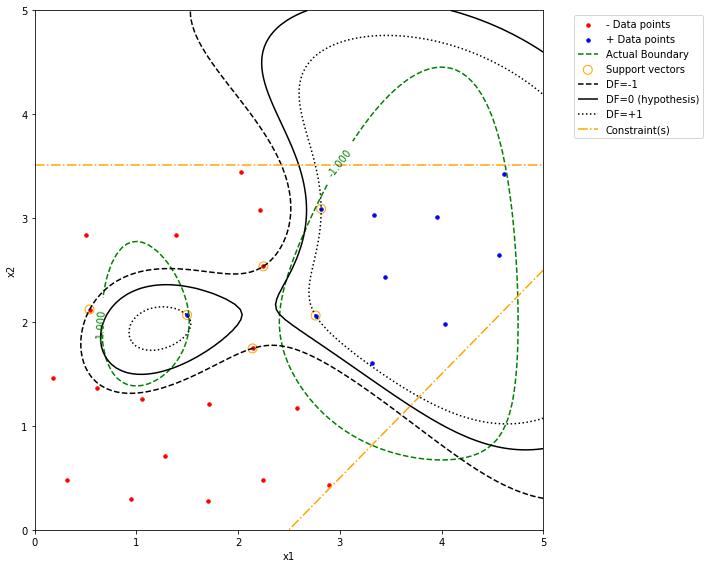

In [6]:
plotSpace(mySpace, 
        classifier=clf, 
        figsize = (10,8), 
        legend = True, 
        showPlot=False,
        saveInfo = sInfo, 
        benchmark = myBench,
         constraints = consVector)

In [7]:
initialReport.stopTime = datetime.now()
initialReport.setStop()
# Defining the exploiter: 
exploiter = GA_Exploiter(space = mySpace, 
                    epsilon = 0.05,
                    batchSize = simConfig.batchSize,
                    convergence_curve=False,
                    progress_bar=True,
                    clf = clf, 
                    constraints = consVector)

# Defining the explorer object:
explorer = GA_Voronoi_Explorer(space = mySpace, 
                    batchSize = simConfig.batchSize,
                    convergence_curve=False, 
                    progress_bar=True, 
                    constraints = consVector)

# Defining the convergence sample that implementes the change measure as well as
#   the performance metrics for the process. 
convergenceSample = ConvergenceSample(mySpace,constraints = consVector)
changeMeasure = [convergenceSample.getChangeMeasure(percent = True, 
                                    classifier = clf, 
                                    updateLabels=True)]

# Getting the initial accuracy:
acc = [convergenceSample.getPerformanceMetrics(benchmark = myBench,
                                            classifier=clf,
                                            percentage = True, 
                                            metricType=PerformanceMeasure.ACCURACY)]
print('Initial accuracy: ', acc[0])   
sampleNumbers = [mySpace.sampleNum]
# Calculating the remaining budget:
currentBudget = budget - initialSampleSize

# Setting up the iteration reports file:
iterationReports = []

# Getting the iteration report after the initial sample:
iterationNum = 0
initialReport.budgetRemaining = currentBudget
initialReport.setChangeMeasure(changeMeasure[0])
initialReport.batchSize = initialSampleSize
initialReport.iterationNumber = iterationNum
initialReport.setMetricResults(initialLabels)
initialReport.setSamples(initialSamples)

iterationReports.append(initialReport)
saveIterationReport(iterationReports, iterationReportFile)

Generating the samples using LHS method. This may take a while...
Initial accuracy:  87.37131091283459
./assets/outputReports/33/iterationReport.yaml


------------------------------------------------------------------------------
Current budget:  140  samples
 The best solution found:                                                                           
 [1.06913932 2.33529783]

 Objective function:
 -0.10108580502229604
 The best solution found:                                                                           
 [1.96444495 2.1669913 ]

 Objective function:
 -0.09136816337982706
 The best solution found:                                                                           
 [0.95499088 3.48994668]

 Objective function:
 -0.1563327269659096
 The best solution found:                                                                           
 [0.01516366 3.46409601]

 Objective function:
 -0.15837934585794203
Hypothesis change estimate:  [7.0006863417982155]  %
Current accuracy estimate:  [90.94028826355525]  %
./assets/outputReports/33/iterationReport.yaml
-------------------------------------------------------------

 The best solution found:                                                                           
 [2.11955317 0.96102511]

 Objective function:
 -0.09420121856481047
Hypothesis change estimate:  [0.8922443376801648]  %
Current accuracy estimate:  [95.12697323266987]  %
./assets/outputReports/33/iterationReport.yaml
------------------------------------------------------------------------------
Current budget:  104  samples
 The best solution found:                                                                           
 [0.68420152 1.85693771]

 Objective function:
 -0.06006477650674132
 The best solution found:                                                                           
 [2.4094938  1.62834177]

 Objective function:
 -0.047544929029814824
 The best solution found:                                                                           
 [0.56083048 0.0078034 ]

 Objective function:
 -0.09634701340959755
 The best solution found:                                  

 The best solution found:                                                                           
 [2.0877741  1.36664275]

 Objective function:
 -0.07669816873076747
 The best solution found:                                                                           
 [3.04217965 2.79563394]

 Objective function:
 -0.07417707649407096
Hypothesis change estimate:  [1.7158544955387784]  %
Current accuracy estimate:  [96.63692518874399]  %
./assets/outputReports/33/iterationReport.yaml
------------------------------------------------------------------------------
Current budget:  68  samples
 The best solution found:                                                                           
 [2.51877706 1.51865368]

 Objective function:
 -0.03096727869232187
 The best solution found:                                                                           
 [0.79463391 2.69682766]

 Objective function:
 -0.034545466052860574
 The best solution found:                                   

 The best solution found:                                                                           
 [0.62161858 1.98507045]

 Objective function:
 -0.028519903395470766
 The best solution found:                                                                           
 [0.65273271 2.42093209]

 Objective function:
 -0.027875000292540027
 The best solution found:                                                                           
 [3.38251419 3.34936776]

 Objective function:
 -0.0625896257473426
 The best solution found:                                                                           
 [1.05163368 0.93382694]

 Objective function:
 -0.06453363087854672
Hypothesis change estimate:  [0.06863417982155114]  %
Current accuracy estimate:  [97.66643788606726]  %
./assets/outputReports/33/iterationReport.yaml
------------------------------------------------------------------------------
Current budget:  32  samples
 The best solution found:                                  

Hypothesis change estimate:  [0.41180507892930684]  %
Current accuracy estimate:  [97.11736444749485]  %
./assets/outputReports/33/iterationReport.yaml


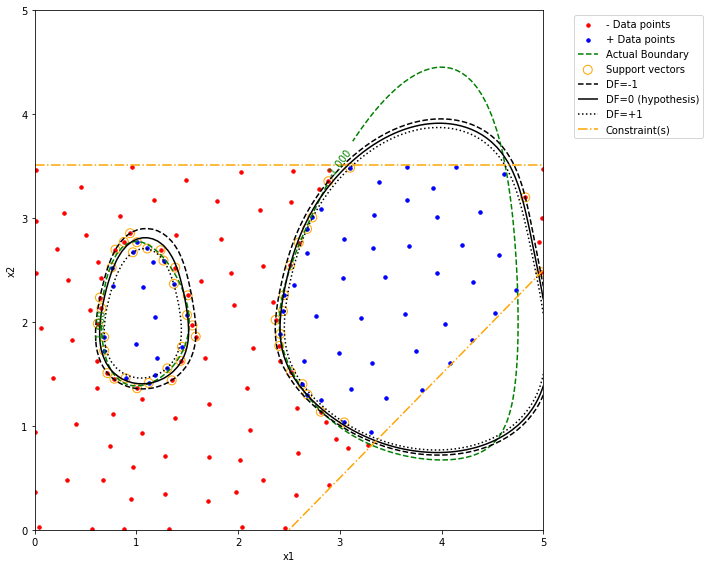

In [8]:

while currentBudget > 0:
    print('------------------------------------------------------------------------------')
    # Setting up the iteration report timing members:
    iterationNum += 1
    iterReport = IterationReport(dimNames, batchSize=batchSize)
    iterReport.setStart()
    print('Current budget: ', currentBudget, ' samples')
    # Finding new points using the exploiter object:
    # NOTE: The classifier has to be passed everytime to the exploiter for update.
    # exploiterPoints = exploiter.findNextPoints(min(currentBudget, batchSize))
    exploiterPoints = exploiter.findNextPoints(pointNum=exploitationBudget)
    explorerPoints = explorer.findNextPoints(pointNum=explorationBudget)
    # Updating the remaining budget:    
    currentBudget -= min(currentBudget, batchSize) 
    # Visualization and saving the results:
    sInfo.fileName = f'{figFolder}/bdgt_{currentBudget}_NotLabeled'
    plotSpace(mySpace, 
        figsize = (10,8),
        legend = True, 
        showPlot=False, 
        classifier = clf,
        saveInfo=sInfo,
        newPoints=exploiterPoints,
        explorePoints=explorerPoints,
        benchmark = myBench,
        constraints = consVector)
    plt.close()
    # Evaluating the newly found samples: 
    newLabels = myBench.getLabelVec(exploiterPoints)
    exploreLabels = myBench.getLabelVec(explorerPoints)
    # Adding the newly evaluated samples to the dataset:
    mySpace.addSamples(exploiterPoints, newLabels)
    mySpace.addSamples(explorerPoints, exploreLabels)
    # Training the next iteration of the classifier:
    clf = StandardClassifier(kernel = 'rbf', C=1000)
    clf.fit(mySpace.samples, mySpace.eval_labels)
    exploiter.clf = clf
    # Calculation of the new measure of change and accuracy after training:
    newChangeMeasure = convergenceSample.getChangeMeasure(percent = True, 
                                            classifier = clf, 
                                            updateLabels=True)
    changeMeasure.append(newChangeMeasure)
    newAccuracy = convergenceSample.getPerformanceMetrics(benchmark = myBench, 
                                            percentage=True, 
                                            classifier=clf,
                                            metricType=PerformanceMeasure.ACCURACY)
    acc.append(newAccuracy)
    print('Hypothesis change estimate: ', changeMeasure[-1:], ' %')
    print('Current accuracy estimate: ', acc[-1:], ' %')
    sampleNumbers.append(mySpace.sampleNum)
    # Visualization of the results after the new samples are evaluated:
    sInfo.fileName = f'{figFolder}/bdgt_{currentBudget}_Labeled'
    plotSpace(space = mySpace,
        figsize = (10,8),
        legend = True,
        classifier = clf, 
        benchmark = myBench,
        newPoints=None,
        saveInfo=sInfo,
        showPlot=False,
        constraints = consVector)
    plt.close()
    # Adding the iteration information to the report for saving.
    iterReport.setStop()
    iterReport.budgetRemaining = currentBudget
    iterReport.iterationNumber = iterationNum
    iterReport.setMetricResults(newLabels)
    iterReport.setExploitatives(exploiterPoints)
    iterReport.setExplorers(explorerPoints)
    iterReport.setChangeMeasure(newChangeMeasure)
    iterationReports.append(iterReport)
    saveIterationReport(iterationReports, iterationReportFile)

# Final visualization of the results: 
plotSpace(space = mySpace, figsize=(10,8), legend = True,
                        saveInfo=sInfo, showPlot=True, classifier = clf, 
                        benchmark = myBench, constraints = consVector)
